# S2S RNN to predict next state

We aim to predict the next steps on time series

In [9]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pprint as pprint
import math
import time

In [10]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [11]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import os
import json
import pickle
import sklearn
from sklearn import neighbors

In [12]:
import import_ipynb

import Process_Training_Data_2

from Process_Training_Data_2 import norm
from Process_Training_Data_2 import denorm
from Process_Training_Data_2 import class_to_action
from Process_Training_Data_2 import closest_category

### Get the data
First Import it using pandas

In [13]:
dataset_short = Process_Training_Data_2.get_data("./data/OSPA_training_data 2.csv")

action_vector = ["A0","A1"]
normed_dataset = Process_Training_Data_2.normalize_data(dataset_short,action_vector)

N_STEPS = 8
position = "post"
dataset2 = Process_Training_Data_2.padding(normed_dataset,N_STEPS,position)

In [14]:
Zero_Target= [0,0,0,0,0,0]
data_stats=pd.read_csv("./data/data_stats2.csv")
ZT_norm = norm(Zero_Target, data_stats)
ZT_norm 

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: std, dtype: float64

### Split the data into train and test

Now split the dataset into a training set and a test set.

We take the first TRAIN_SPLIT values as train data

We will use the test set in the final evaluation of our model.

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [15]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, prediction_type):
  data = []
  labels = []

  if end_index is None:
    end_index = len(dataset)

  for i in range(start_index, end_index):
    indices = range(0, history_size)
    data.append(dataset[i,indices,:])

    if prediction_type is "single_step":
      labels.append(target[i,history_size + target_size])
    elif prediction_type is "multiple_step":
      labels.append(target[i,history_size:history_size+target_size])
    elif prediction_type  is "sequence":
      labels.append(target[i, 1:history_size + 1])   

  return np.array(data), np.array(labels)

## single step model using sequential output
Given a sequence of actions, the model should predict the same sequency one step in the future

### Split features from labels

In [16]:
np.random.shuffle(dataset2)

In [17]:
TRAIN_SPLIT = int(len(dataset2)*0.8)
past_history = N_STEPS
future_target = 0
STEP = N_STEPS+1
prediction_type ="sequence"
features_dataset = dataset2[:,:STEP,:6]
target_dataset = dataset2[:,0:,:6]

x_train_single_sequential, y_train_single_sequential = multivariate_data(features_dataset, target_dataset,0, TRAIN_SPLIT, past_history, future_target, STEP, prediction_type)

x_val_single_sequential, y_val_single_sequential = multivariate_data(features_dataset, target_dataset, TRAIN_SPLIT, None, past_history, future_target, STEP, prediction_type)

In [18]:
print ('Single window of past history : {}'.format(x_train_single_sequential[0].shape))

Single window of past history : (8, 6)


In [19]:
BATCH_SIZE = 1
# BUFFER_SIZE = 10000

train_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_train_single_sequential, y_train_single_sequential))
train_data_single_sequential = train_data_single_sequential.cache().batch(BATCH_SIZE).repeat()

val_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_val_single_sequential, y_val_single_sequential))
val_data_single_sequential = val_data_single_sequential.batch(BATCH_SIZE).repeat()

### Build the model

sample_weight

In [20]:

sample_weight= tf.constant([[[1,1,1,1,1,1],[2,2,2,2,2,2],[3,3,3,3,3,3],[3,3,3,3,3,3],[3,3,3,3,3,3],[3,3,3,3,3,3],[3,3,3,3,3,3],[3,3,3,3,3,3]]])
sample_weight

<tf.Tensor: shape=(1, 8, 6), dtype=int32, numpy=
array([[[1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3, 3]]])>

In [21]:
single_step_sequential_model = tf.keras.models.Sequential()
single_step_sequential_model.add(tf.keras.layers.LSTM(11,return_sequences=True, input_shape=(None, 6)))
single_step_sequential_model.add(tf.keras.layers.Dense(6, activation='linear'))

loss_fn = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')

single_step_sequential_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss=loss_fn, metrics=['mse','mae'])

### Inspect the model

In [22]:
single_step_sequential_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 11)          792       
_________________________________________________________________
dense (Dense)                (None, None, 6)           72        
Total params: 864
Trainable params: 864
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [23]:
STEPS_PER_EPOCH = TRAIN_SPLIT / BATCH_SIZE
EPOCHS = 100

single_step_sequential_history = single_step_sequential_model.fit(train_data_single_sequential, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=val_data_single_sequential, validation_steps=50)

Train for 192.0 steps, validate for 50 steps
Epoch 1/100
192/192 [==============================] - 8s 41ms/step - loss: 1.4465 - mse: 1.4465 - mae: 0.8990 - val_loss: 0.7121 - val_mse: 0.7121 - val_mae: 0.6195
Epoch 2/100
192/192 [==============================] - 2s 10ms/step - loss: 0.6124 - mse: 0.6124 - mae: 0.5617 - val_loss: 0.4491 - val_mse: 0.4491 - val_mae: 0.4717
Epoch 3/100
192/192 [==============================] - 2s 8ms/step - loss: 0.4601 - mse: 0.4601 - mae: 0.4725 - val_loss: 0.3723 - val_mse: 0.3723 - val_mae: 0.4187
Epoch 4/100
192/192 [==============================] - 2s 8ms/step - loss: 0.4016 - mse: 0.4016 - mae: 0.4352 - val_loss: 0.3339 - val_mse: 0.3339 - val_mae: 0.3907
Epoch 5/100
192/192 [==============================] - 2s 8ms/step - loss: 0.3670 - mse: 0.3670 - mae: 0.4112 - val_loss: 0.3087 - val_mse: 0.3087 - val_mae: 0.3719
Epoch 6/100
192/192 [==============================] - 2s 8ms/step - loss: 0.3421 - mse: 0.3421 - mae: 0.3922 - val_loss: 0.2891

In [24]:
N_CATEGORIES = 28
X = pd.DataFrame(columns=["A0", "A1"], dtype=np.float64, index=range(N_CATEGORIES))

for i in range(N_CATEGORIES):
    X["A0"][i] = class_to_action(str(i))[0]
    X["A1"][i] = class_to_action(str(i))[1]


In [25]:
test_loss, test_mse, test_mae = single_step_sequential_model.evaluate(x_val_single_sequential,  y_val_single_sequential, verbose=2)

48/48 - 1s - loss: 0.1391 - mse: 0.1391 - mae: 0.2189


Visualize the model's training progress.

In [26]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

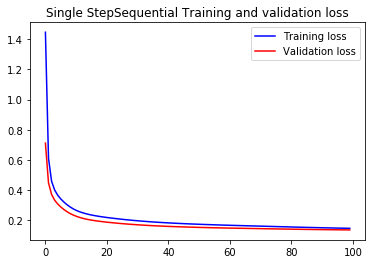

In [27]:
plot_train_history(single_step_sequential_history,
                   'Single StepSequential Training and validation loss')

Compare trajectory

Trajectory component vs steps

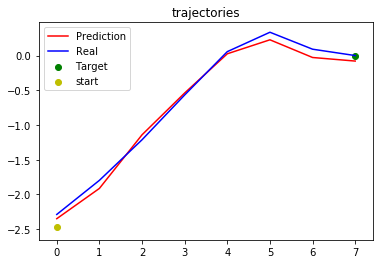

In [28]:
plt.figure()
S_Trajectory_prediction = single_step_sequential_model.predict(x_train_single_sequential)[:,:,:]

t_number = 5

component= 1

plt.plot(S_Trajectory_prediction[t_number][:,component], c='r', label='Prediction')
plt.plot(y_train_single_sequential[t_number][:,component], c='b', label='Real')
plt.scatter(N_STEPS-1, ZT_norm[component],  c='g', label='Target')
plt.scatter(0, x_train_single_sequential[t_number][0,component], c='y', label='start')
plt.title("trajectories")
plt.legend()

plt.show()

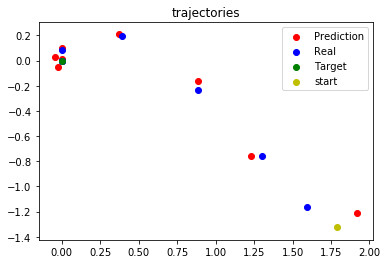

In [29]:
plt.figure()
S_Trajectory_prediction = single_step_sequential_model.predict(x_val_single_sequential)[:,:,0:2]

t_number = 5

plt.scatter(S_Trajectory_prediction[t_number][:,0], S_Trajectory_prediction[t_number][:,1], c='r', label='Prediction')
plt.scatter(y_val_single_sequential[t_number][:,0], y_val_single_sequential[t_number][:,1], c='b', label='Real')
plt.scatter(ZT_norm[0],ZT_norm[1], c='g', label='Target')
plt.scatter(x_val_single_sequential[t_number][0,0], x_val_single_sequential[t_number][0,1], c='y', label='start')
plt.title("trajectories")
plt.legend()

plt.show()

## Decoder Mode

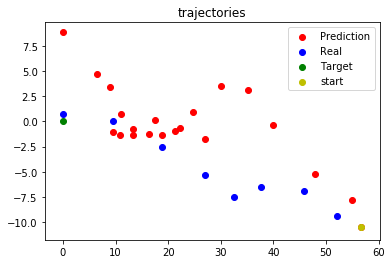

In [79]:
t_number = 18
S_Trajectory_prediction=x_val_single_sequential[t_number,0,:]
S_Trajectory_prediction = np.reshape(S_Trajectory_prediction, (1,1,6))

for i in range(20):

    dummy_trajectory=single_step_sequential_model.predict(S_Trajectory_prediction)
    last_step = np.reshape(dummy_trajectory[:,-1,:],(1,1,6))

    if  (last_step[0,0,0] <= 0.01):
        last_step[0,0,0] = 0
        S_Trajectory_prediction=np.append(S_Trajectory_prediction, last_step, axis=1)
        break
    S_Trajectory_prediction=np.append(S_Trajectory_prediction, last_step, axis=1)

New_trajectory = np.squeeze(S_Trajectory_prediction)

Trajectory_prediction_denorm = np.apply_along_axis(denorm,1,New_trajectory,data_stats)

y_val_denorm = np.apply_along_axis(denorm,1,y_val_single_sequential[t_number],data_stats)

x_val_denorm = np.apply_along_axis(denorm,1,x_val_single_sequential[t_number],data_stats)




plt.figure()

plt.scatter(Trajectory_prediction_denorm[:,0], Trajectory_prediction_denorm[:,1], c='r', label='Prediction')
plt.scatter(y_val_denorm[:,0], y_val_denorm[:,1], c='b', label='Real')
plt.scatter(ZT_norm[0],ZT_norm[1], c='g', label='Target')
plt.scatter(x_val_denorm[0,0], x_val_denorm[0,1], c='y', label='start')
plt.title("trajectories")
plt.legend()

plt.show()


In [72]:
def generate_trajectory_Decoder(model, start, target, initial_action, data_stats):

    model.reset_states()

    # initialize cost
    cost = 0

    # Empty vector to store the actions
    actions = []

    #initialize action vector
    actions.append(initial_action)

    # First point is the initial distance

    # Compute the initial distance
    distance_long = target - start
    
    # normalize to get the Neuronal Network input
    distance = norm(distance_long[0:6], data_stats)
    trajectory_generated = tf.expand_dims([distance], 0)


    for i in range(15):

        dummy_trajectory=model.predict(trajectory_generated)
        last_step = np.reshape(dummy_trajectory[:,-1,:],(1,1,6))

        if  (last_step[0,0,0] <= 0.02):
            last_step[0,0,0] = 0
            trajectory_generated=np.append(trajectory_generated, last_step, axis=1)
            end_message = "End"
            break

        trajectory_generated=np.append(trajectory_generated, last_step, axis=1)
        end_message = "Error"
    
    print(end_message)

    New_trajectory = np.squeeze(trajectory_generated)

    trajectory_generated_denorm = np.apply_along_axis(denorm,1,New_trajectory,data_stats)

    return trajectory_generated_denorm, cost, actions, end_message


#### Adding early stop

In [32]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history_sequential = single_step_sequential_model.fit(train_data_single_sequential, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_single_sequential,
                                          validation_steps=50, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1472,  mae:0.2329,  mse:0.1472,  val_loss:0.1369,  val_mae:0.2179,  val_mse:0.1369,  
....................................................................................................

In [33]:
single_step_sequential_model.save('./data/S2S_S2S_model_2.h5') 

## Get validation statistics

In [42]:
model = tf.keras.models.load_model('./data/S2S_S2S_model_2.h5')

In [52]:
def distance_error(x, z):
    distancia = math.sqrt(x**2 + z**2)
    return distancia

In [73]:
val_results = pd.DataFrame(columns = ["path", "actions", "distance", "cost", "end_message"])

for t_number in range(len(y_val_single_sequential)):

    x_val_denorm = np.apply_along_axis(denorm,1,x_val_single_sequential[t_number],data_stats)

    y_val_denorm = np.apply_along_axis(denorm,1,y_val_single_sequential[t_number],data_stats)

    initial_action = [0,0]
    start = [0.0, 0.0, 4.257165346815115, 0.0, 0, 0]
    target = x_val_denorm[0] + start

    start_time = time.time()

    trajectory, cost, actions, end_message = generate_trajectory_Decoder(model, start, target, initial_action, data_stats)

    val_results.at[t_number, "time"] = time.time() - start_time
    val_results.at[t_number, "actions"] = np.array(actions)
    val_results.at[t_number, "path"] = np.array(trajectory)
    val_results.at[t_number, "cost"] = cost
    val_results.at[t_number, 'distance'] = distance_error(*trajectory[-1,0:2])
    val_results.at[t_number, 'end_message'] = end_message



End
Error
End
Error
End
End
End
End
End
End
Error
Error
End
End
End
Error
End
End
Error
End
End
End
End
End
End
End
Error
Error
End
End
End
Error
Error
End
End
Error
End
End
End
Error
End
Error
End
End
End
Error
End
Error


In [74]:
val_table = pd.DataFrame(columns = ["all","result_end", "result_error"])

val_table.at['distance', "result_end"] = val_results['distance'].loc[val_results['end_message'] == "End"].mean()
val_table.at['distance', "result_error"] = val_results['distance'].loc[val_results['end_message'] == "Error"].mean()
val_table.at['distance', "all"] = val_results['distance'].mean()

val_table.at["time", "result_end"] = val_results["time"].loc[val_results['end_message'] == "End"].mean()
val_table.at["time", "result_error"] = val_results["time"].loc[val_results['end_message'] == "Error"].mean()
val_table.at["time", "all"] = val_results["time"].mean()

print(val_results["time"].loc[val_results['end_message'] == "Error"].count()/len(y_val_single_sequential))
val_table


0.3125


,all,result_end,result_error
distance,6.51414,1.54914,17.4371
time,0.445003,0.328461,0.701397


## Compare with heuristic results

In [34]:
from ast import literal_eval
samples = pd.read_csv("./data/heuristic_samples_metric.csv", converters={'initial_state': literal_eval, 'final_state': literal_eval, 'h_actions': literal_eval, 'h_path': literal_eval})

In [35]:
col = ['D0','D1','D2','D3','D4','D5']
distances = []
for sample_id, row in samples.iterrows():
    target = np.array(results['final_state'][sample_id])
    for sample in  samples['h_path'][sample_id]:
        distances.append(target[0:6]-sample[0:6])
distances = np.array(distances)
df = pd.DataFrame (distances, columns = col)
data_stats_T = df.describe()
data_stats_T = data_stats_T.transpose()
data_stats_T

NameError: name 'results' is not defined

In [130]:
results= samples.copy()
for sample_id, row in results.iterrows():
    print(sample_id)
    initial_action = np.array(results['h_actions'][sample_id][0])
    start = np.array(results['initial_state'][sample_id])
    target = np.array(results['final_state'][sample_id])
    start_time = time.time()
    trajectory, cost, actions, end_message = generate_trajectory_Decoder(model, start, target, initial_action, data_stats_T)
    results.at[sample_id, "h_time"] = time.time() - start_time
    results.at[sample_id, "h_actions"] = np.array(actions)
    results.at[sample_id, "h_path"] = np.array(trajectory)
    results.at[sample_id, "h_cost"] = cost
    results.at[sample_id, 'h_distance'] = distance_error(*trajectory[-1,0:2])
    results.at[sample_id, 'end_message'] = end_message

0
End
1
Error
2
End
3
End
4
Error
5
End
6
Error
7
End
8
End
9
End
10
End
11
End
12
End
13
End
14
End
15
Error
16
End
17
End
18
End
19
Error
20
End
21
Error
22
End
23
End
24
End
25
End
26
End
27
End
28
Error
29
End
30
End
31
End
32
End
33
End
34
End
35
Error
36
Error
37
End
38
End
39
End
40
End
41
End
42
End
43
End
44
Error
45
End
46
End
47
End
48
Error
49
End
50
Error
51
End
52
End
53
Error
54
End
55
End
56
End
57
End
58
Error
59
End
60
Error
61
End
62
End
63
Error
64
Error
65
End
66
End
67
Error
68
Error
69
Error
70
Error
71
End
72
End
73
Error
74
End
75
End
76
End
77
End
78
End
79
Error
80
Error
81
Error
82
Error
83
End
84
End
85
Error
86
End
87
End
88
Error
89
End
90
End
91
End
92
Error
93
End
94
End
95
Error
96
End
97
End
98
End
99
End


In [69]:
comparsion_table = pd.DataFrame(columns = ["sample", "result_end", "result_error"])
comparsion_table.at["h_cost", "sample"] = samples["h_cost"].mean()
comparsion_table.at["h_cost", "result_end"] = results["h_cost"].loc[results['end_message'] == "End"].mean()
comparsion_table.at["h_cost", "result_error"] = results["h_cost"].loc[results['end_message'] == "Error"].mean()

comparsion_table.at['h_distance', "sample"] = samples['h_distance'].mean()
comparsion_table.at['h_distance', "result_end"] = results['h_distance'].loc[results['end_message'] == "End"].mean()
comparsion_table.at['h_distance', "result_error"] = results['h_distance'].loc[results['end_message'] == "Error"].mean()
comparsion_table

comparsion_table.at['h_time', "sample"] = samples["h_time"].mean()
comparsion_table.at["h_time", "result_end"] = results["h_time"].loc[results['end_message'] == "End"].mean()
comparsion_table.at["h_time", "result_error"] = results["h_time"].loc[results['end_message'] == "Error"].mean()
comparsion_table


NameError: name 'results' is not defined

## Plot one single trajectory

End
[2048.80449952 2340.53041755 2093.55198043 1867.83739053 1471.38756184
 1063.83932337  623.79563248  222.81102267    0.        ]


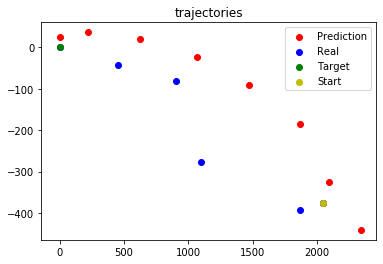

In [141]:
sample_id = 7
initial_action = np.array(samples['initial_state'][sample_id][6:8])
start = np.array(samples['initial_state'][sample_id][0:6])
target = np.array(samples['final_state'][sample_id][0:6])
distancia_inicial = target - start
teorico = []
for sample in  samples['h_path'][sample_id]:
    teorico.append(sample[0:6])
teorico = np.array(teorico)

trajectory, cost, actions, end_message= generate_trajectory_Decoder(model, start, target, initial_action, data_stats_T)
trajectory = np.array(trajectory)
print(trajectory[:,0])

plt.figure()

plt.scatter(trajectory[:,0], trajectory[:,1], c='r', label='Prediction')
plt.scatter(teorico[:,0], teorico[:,1], c='b', label='Real')
plt.scatter(ZT_norm[0],ZT_norm[1], c='g', label='Target')
plt.scatter(distancia_inicial[0],distancia_inicial[1], c='y', label='Start')
plt.title("trajectories")
plt.legend()

plt.show()

